# Analysis for Insight Project

## Setup

In [207]:
# import modules
import pandas as pd
import numpy as np
import rootpath
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics
from sklearn.utils import resample

from sklearn.metrics.pairwise import cosine_similarity as cos_sim

# Plotting

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  
import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

### Locate files

In [175]:
# Set paths for project

# Set rootpath for project
rpath = rootpath.detect()

# Set directory
directory_name = '/data/clean/'

# Set filename
file_name = 'data_tsvd_full.csv'

### Compile data

In [176]:
df_tsvd_full = pd.read_csv(rpath+directory_name+file_name, index_col=0)

# Analysis: Cosine similarity

## Determine number of components to extract for LSA

In [177]:
def get_features(df, prod_info):
    """
    Purpose: extract ingredient features from tsvd dataframe
    Returns: df of ingredient features only
    df: df of tsvd and product info
    prod_info: list of strings of column names to remove
    """
    df_tsvd_full_features = df.drop(prod_info, axis=1) \
                                    .set_index('product')
    
    return df_tsvd_full_features

In [178]:
# Separate features from product information

prod_info = ['use_category', 'brand', 'brand_generic',
             'size', 'price', 'link']

df_tsvd_full_features = get_features(df_tsvd_full, prod_info)

In [179]:
def filter_string(list_of_strings, string_to_remove):
    """
    Purpose: filters a string(s) from a list of strings
    Returns: a list without the indicated string(s)
    string_to_remove: MUST BE A LIST
    """
    new_list = [string for string in list_of_strings \
                    if string not in string_to_remove]
    return new_list

In [180]:
# Extract brand_generic product labels

brand_gen_labels = (
    filter_string(df_tsvd_full['brand_generic'].unique(),'non_generic')
)

In [181]:
# List of brand name product brands 
# This does not include their generic versions

brand_names = ['Aveeno','Banana boat','Cetaphil','Clean and Clear',
               'St. Ives']

In [182]:
# Extract df of brand_generic products for comparison to similarity output

# Get columns of product info only

df_brand_gen = (
    df_tsvd_full[df_tsvd_full.columns.intersection(prod_info)].copy()
)

# Add product

df_brand_gen['product'] = df_tsvd_full['product']

# Filter out only brand_generic products

df_brand_gen = df_brand_gen.query('brand_generic == @brand_gen_labels')

In [183]:
# Extract product names for brand name products only
# These are the input products for checking recommendation
#   accuracy for specific products

brand_name_prod = (
    df_tsvd_full.query('brand_generic == @brand_gen_labels and \
                        brand == @brand_names')['product']
)

In [184]:
def reorder_first_cols(df, col_order):
    '''
    Reorder columns in dataframe with col_order as a list of column names
    in the order you want them in to appear at the beginner of the dataframe.
    The rest of the columns will remain in the same order as before. 
    '''
    # Create new column ordering
    new_col_order = (
          col_order + [col for col in df.columns if col not in col_order]
    )
    # Reindex columns based on new order
    df = df.reindex(columns=new_col_order)
    
    return df

In [185]:
def add_prod_info(new_df, original_df, col_names, prod_names_col):
    """
    Purpose: Add product information to TSVD dataframe
    Returns: dataframe with product information in rows and columns
    new_df: df with cosine similarity results results
    original_df: df before tsvd with product information
    col_names: List of strings of column names to be added into tsvd df
    prod_names_col: Name of column with product names, string
    """
    # Add product names
    new_df['product']=original_df[prod_names_col]
    # Copy columns to new df
    col_copy = original_df[col_names].copy()
    # Copy product names to col names df
    col_copy['product'] = original_df[prod_names_col]
    # Join with tsvd df on product
    new_df = pd.merge(new_df, col_copy, how='inner', on='product')
    # Reorder df columns
    cols_order = ['product','cosine_sim', 'use_category','brand',
                  'brand_generic','size','price','link']
    new_df = reorder_first_cols(new_df, cols_order)
    return new_df

In [186]:
def get_prod_rec_acc(prod_list, prod_df, feat_df):
    """
    Purpose: Check performance of recommendations for list of products.
    Returns: df of the results for each input product in prod_list
    prod_list: list of product names for calculating cosine similarities
    prod_df: dataframe of cosine sim with products as rows 
    feat_df: dataframe of cosine sim only with products as indices
    """
    # Set initial value for number of valid recommendations
    correct_rec = []
    input_prod = []
    top_output_prod = []
    top_cos_sim = []    
    
    # Check recommendation accuracy for each product in prod_list
    for product in prod_list:
        # Calculate Cosine Similarities
        res_cosine = (
            cos_sim(feat_df.loc[[product],:],
                              feat_df)
        )
        # Convert to df
        res_cosine = pd.DataFrame(res_cosine.transpose()) \
                       .rename(columns={0:'cosine_sim'})
        # Add product info to cosine sim results
        df_cos_sim = add_prod_info(new_df=res_cosine,
                                   original_df=prod_df,
                                   col_names=prod_info, 
                                   prod_names_col='product')
        # Round to 4 digits
        df_cos_sim['cosine_sim'] = df_cos_sim['cosine_sim'].round(4)
        # Extract top 6 most similar results
        df_cos_sim_topres = df_cos_sim.nlargest(6,'cosine_sim')
        # Filter df without input product 
        #   (should always be with cosine sim of 1)
        df_cos_sim_topres = (
            df_cos_sim_topres[~df_cos_sim_topres['product'].isin([product])]
        )
        # Get brand generic label for input product
        input_prod_label = (
            df_brand_gen.query('product in @product')['brand_generic']
        )
        # Get brand_generic label for top result
        top_res_prod_label = (
            df_cos_sim_topres.nlargest(1,'cosine_sim')['brand_generic']
        )
        # Compare brand_generic label of input product and add 1 if it matches
        if input_prod_label.values == top_res_prod_label.values:
            correct_rec.append(True)
        else:
            correct_rec.append(False)
        # Save the input product, comparison product, similarity 
        input_prod.append(product)
        top_output_prod.extend(
            df_cos_sim_topres.nlargest(1,'cosine_sim')['product'].tolist()
        )
        top_cos_sim.extend(
            df_cos_sim_topres.nlargest(1,'cosine_sim')['cosine_sim'].tolist()
        )

    # Add lists together and turn into df 
    df_valid_res = (
        pd.DataFrame(list(zip(input_prod, top_output_prod, top_cos_sim, 
                              correct_rec)),
                     columns=['input_prod','top_output_prod','cos_sim',
                                      'correct_rec'])
    )
    
    return df_valid_res

In [187]:
# Get recommendation accuracy for list of brand name products

df_valid_res = get_prod_rec_acc(brand_name_prod, prod_df=df_tsvd_full,
                                feat_df=df_tsvd_full_features)

In [188]:
def get_overall_rec_acc(df, print_res=True):
    """
    Purpose: print proportion and percent correct results from cos_sim results
    Returns:
    df: df of cosine sim results for a list of products
    """
    # Calculate percentage of correct recommendations
    num_correct = sum(df['correct_rec'].values)
    per_correct = [round((num_correct/6) * 100,2)]
    # convert num_correct to list for zip
    num_correct = [num_correct]
    df_acc_res = pd.DataFrame(list(zip(num_correct, per_correct)),
                              columns=['num_correct','perc_correct'])
    if print_res:
        print(f"Correct recommendations out of 6 labeled products: \
        {num_correct[0]}/6 or {per_correct[0]}%")
    
    return df_acc_res

In [233]:
def get_components_df(df, ending_component):
    """
    Purpose: Extract a range of n components from dataframe
    Returns: DF with a range of n components
    starting_comp: string label of the component column to start at
    ending_component: string label of the component column to end at
    """
    # Select n number of components
    df_tsvd_reduced = df.loc[:, '0':str(ending_component)]
    # Set index as product
    df_tsvd_reduced.index = df['product']
    return df_tsvd_reduced

In [197]:
# Get recommendation accuracy for each number of components

component_n = []
comp_perc_correct = []

for component in range(50,400):
    # Get df of the component features
    df_comp = get_components_df(df_tsvd_full, str(component))
    # Get recommendation accuracy for list of brand name products
    df_valid_res = get_prod_rec_acc(brand_name_prod, prod_df=df_tsvd_full,
                                    feat_df=df_comp)
    # Check recommendation accuracy for list of brand name products
    df_cos_sim_val_res = get_overall_rec_acc(df_valid_res, print_res=False)
    
    # Add recommender accuracy and component to lists
    component_n.append(component)
    comp_perc_correct.extend(df_cos_sim_val_res['perc_correct'].tolist())
    
# Create df of results
df_comp_res = pd.DataFrame(list(zip(component_n, comp_perc_correct)),
                          columns=['n_components','perc_correct'])

In [222]:
# Save component results

filename = 'component_accuracy.csv'

df_comp_res.to_csv(rpath+directory_name+filename)

Text(0, 0.5, 'Percent Correct Recommendations')

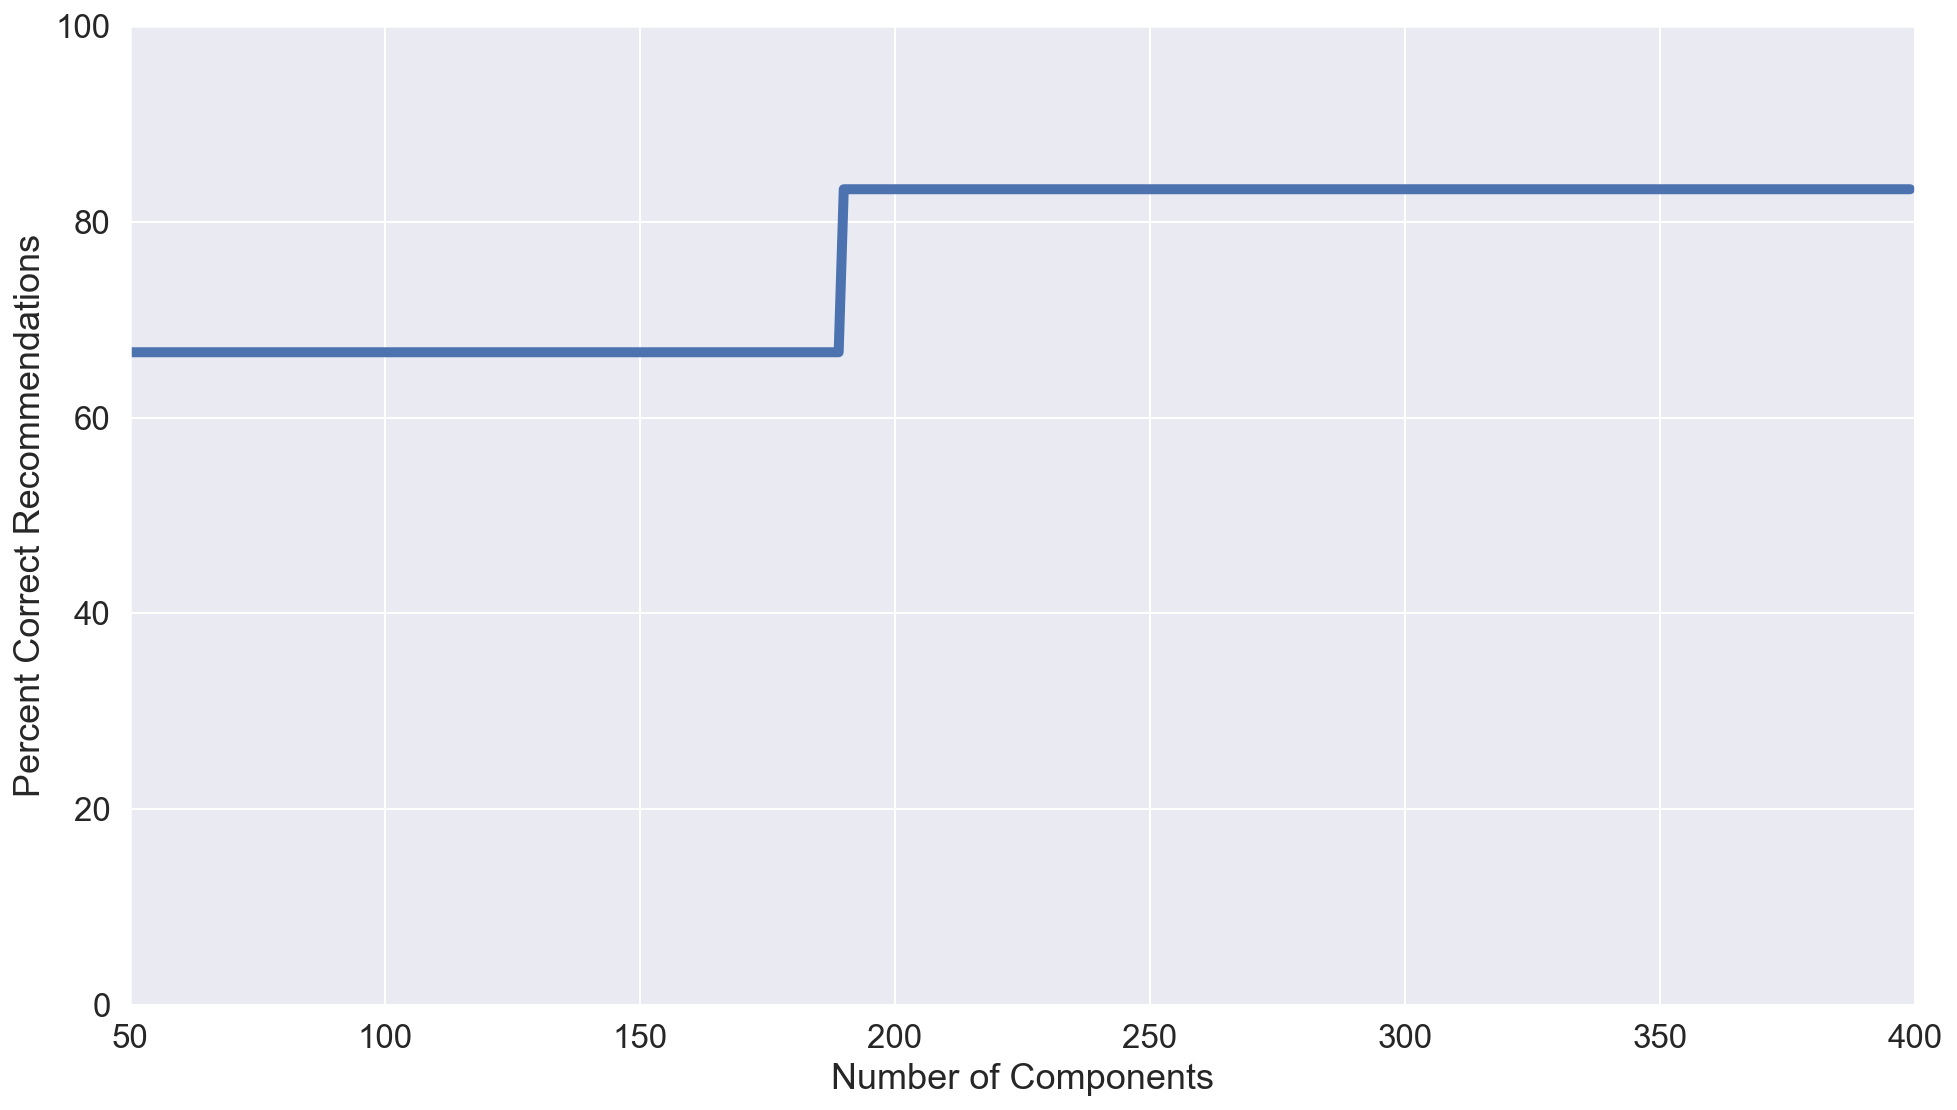

In [210]:
#df_comp_res.plot()

plt.plot(df_comp_res['n_components'], df_comp_res['perc_correct'],
        linewidth=5)
plt.xlim(50, 400)
plt.ylim(0, 100)
plt.xlabel("Number of Components")
plt.ylabel("Percent Correct Recommendations")

In [229]:
def select_best_n_components(df, selection_criteria):
    """
    Purpose: Find the best number of components to use 
    Returns: Number of components to use and the corresponding accuracy
    df: Dataframe of components and percent accuracy results
    selection_criteria: value to use to select the minimum number of 
        components
    """
    # Find the smallest number of components that meet the selection criteria
    n_comp = df[df['perc_correct']==selection_criteria] \
                    .nsmallest(1, 'n_components') \
                    ['n_components'].values
    # change to integer
    n_comp = int(n_comp)
    return n_comp    

In [230]:
int(best_n_comp)

190

In [232]:
# Find the best number of components to use

selection_criteria = df_comp_res['perc_correct'].max()

best_n_comp = select_best_n_components(df_comp_res,
                                    selection_criteria)

print(f"{best_n_comp} is the minimum number of components needed to reach the max recommendation accuracy of {selection_criteria}%")

190 is the minimum number of components needed to reach the max recommendation accuracy of 83.33%


## Validation
### Recommendations for brand vs. generic versions

In [236]:
# Update number of components to use

df_tsvd_full_features = get_components_df(df_tsvd_full, best_n_comp) 

In [238]:
# Update recommendation accuracy for list of brand name products

df_valid_res = get_prod_rec_acc(brand_name_prod, prod_df=df_tsvd_full,
                                feat_df=df_tsvd_full_features)

In [239]:
# Check recommendation accuracy for list of brand name products

df_cos_sim_val_res = get_overall_rec_acc(df_valid_res)
df_cos_sim_val_res

Correct recommendations out of 6 labeled products:         5/6 or 83.33%


,num_correct,perc_correct
0,5,83.33


### Recommendations for brand vs. generic versions - randomization result

In [240]:
def get_prod_rec_acc_rand(prod_list, df_tsvd, randiter):
    """
    Purpose: Gets recommendation accuracy results from randomization with 
        randiter reshuffling. Recommended minimum is 1000
    Returns: df of randomization results
    prod_list: list of product names for calculating cosine similarities
    df_tsvd: dataframe of tsvd results
    randiter: Number of randomization iterations to run
    """

    from numpy import random
    import sys, os
    
    # Initialize empty lists for storing results
    iteration = []
    prop_correct = []
    
    # create list of non-feature columns for the get_features function
    prod_info = ['use_category', 'brand', 'brand_generic',
                 'size', 'price', 'link']
    
    # Perform randomization and calculate correct recommendations each time
    for i in range(randiter-1):
        # Randomize the product names for tsvd results df 
        df_tsvd['product'] = random.permutation(df_tsvd['product'].values)
        # get df of randomized features (using reduced number of components)
        df_tsvd_feat = get_components_df(df_tsvd_full, best_n_comp) 
        # Get accuracy of recommendations
        df_valid_res = get_prod_rec_acc(prod_list, 
                                        prod_df=df_tsvd,
                                        feat_df=df_tsvd_feat)
        # Check recommendation accuracy for list of brand name products
        df_valid_acc = get_overall_rec_acc(df_valid_res, print_res=False)
        # Append results to lists
        iteration.append(i)
        prop_correct.extend(df_valid_acc['perc_correct'].tolist())
    
    # Concatenate results into df
    df_overall_acc_res = pd.DataFrame(list(zip(iteration, prop_correct)),
                                      columns=['iteration','perc_correct'])
    
    return df_overall_acc_res

In [241]:
# Get results from randomization

df_rand_res = get_prod_rec_acc_rand(prod_list=brand_name_prod,
                                    df_tsvd=df_tsvd_full,
                                    randiter=1000)

In [244]:
# Save randomization output

filename = 'data_brand_gen_rand.csv'
df_rand_res.to_csv(rpath+directory_name+filename)

In [242]:
def get_acc_p_val(original_df, rand_df):
    """
    Purpose: Print the p-value for the results observed compared to random 
        chance expectation
    Returns:
    original_df: df of results from original 
        accuracy assessment of recs
    rand_df: df of results from randomization
    """
    # Get original accuracy 
    perc_corr_original = original_df['perc_correct'][0]

    # Get the proportion of randomization results that were equal to 
    #   or greater than the original accuracy
    rand_p_val = (
        (rand_df.perc_correct[rand_df['perc_correct'] >= \
                             perc_corr_original].sum()/1000) * 100
    )
    
    text = f"The probability of observing the original recommendation " \
           f"accuracy of {perc_corr_original}% if the results were due " \
           f"to random chance is {rand_p_val}%"

    print(text)
    
    return rand_p_val

In [243]:
rand_p_val = get_acc_p_val(df_cos_sim_val_res, df_rand_res)

The probability of observing the original recommendation accuracy of 83.33% if the results were due to random chance is 0.0%


In [245]:
# calculate the average accuracy from the randomization results

rand_mean_acc = round(df_rand_res['perc_correct'].mean(),2)
rand_med_acc = round(df_rand_res['perc_correct'].median(),2)

print(f"The average recommendation accuracy for the 1000 randomizations " \
      f"is: {rand_mean_acc}%")
print(f"The median recommendation accuracy for the 1000 randomizations " \
      f"is: {rand_med_acc}%")

The average recommendation accuracy for the 1000 randomizations is: 0.3%
The median recommendation accuracy for the 1000 randomizations is: 0.0%


# ADD THE RANGE to the above, then move onto the prod type. For prod type, do train test split of 0.2! 

In [ ]:
# Calculate cosine similarity for feature 1 
res_cosine = cosine_similarity(features.loc['A+ High-Dose Retinoid Serum',:].to_frame().transpose(), features) #[0:1] .loc["Essential-C Cleanser",:]
res_cosine = res_cosine.reshape(-1)
res_cosine = pd.DataFrame(res_cosine)
res_sim=df[['product','brand','product_type','price','size','ratings', 'active','vit_a',
            'total_reviews','link','price_oz']].copy()
res_sim['similarity']=res_cosine[[0]]
# Round similarity metric
#res_sim['similarity']=round(res_sim['similarity'],2)
# Maybe don't round so you don't have to deal with ties?
#indexNames = res_sim[res_sim['product']=='Essential-C Cleanser'].index
#res_sim.drop(indexNames, inplace=True)
# Sort from top similarity metrics and ignoring self, so starting at 1, not zero
test = res_sim.nlargest(5, 'similarity')[1:5]
#res_sim.head()
# Select top match
test[:10]
#Good Genes All-In-One Lactic Acid Treatment
#A+ High-Dose Retinoid Serum
# Generic vs similar validation
# Cetaphil Daily Facial Cleanser
# Cetaphil Fragrance Free Moisturizing Cream : 0.959282
# Banana Boat Ultra Sport Sunscreen Lotion, Broad Spectum SPF 30 : 0.999971
# St. Ives Fresh Skin Face Scrub, Apricot : 0.999748
# Clean & Clear Essentials Deep Cleaning Toner Sensitive Skin : 0.999994
# Aveeno Positively Radiant Brightening & Exfoliating Face Scrub : 0.990599

#test[test['vit_a']==1]